# Introduction : objectives

The purpose of this notebook is to calculate and plot footprints for specific periods with the Kljun et al. (2015) FFP model. 

# Importation of packages and modules

This notebook was developed with:  
- Python 3.13.2  
- Jupyter Notebook  
- Libraries : pandas, numpy, matplotlib, contextily, rasterio, xarray, glob, os, tqdm
- Modules : data_preparation, footprint_analysis, calc_footprint_FFP_climatology
- See 'environment.yml' in the repository for more infos. 

In [49]:
import sys
sys.path.append('/home/jovyan//ICOS-M2-internship-alise/scripts/')

In [71]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import data_preparation as datprep
import footprint_analysis as FFP_analys
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
import contextily as cx
from rasterio.transform import rowcol
import rasterio
import rasterio.plot
from rasterio.windows import from_bounds
import xarray as xr
from matplotlib.lines import Line2D
import matplotlib.ticker as mticker
import glob
import os
from tqdm import tqdm
import calc_footprint_FFP_climatology as myfootprint_climato

#Pour mettre à jour les modules
import importlib
importlib.reload(datprep)
importlib.reload(FFP_analys)

import watermark
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [58]:
%watermark --iversions

sys       : 3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 14:10:22) [GCC 13.3.0]
numpy     : 2.2.4
geopandas : 1.0.1
tqdm      : 4.67.1
folium    : 0.19.5
pandas    : 2.2.3
watermark : 2.5.0
shapely   : 2.0.7
matplotlib: 3.10.1
pyproj    : 3.7.1
contextily: 1.6.2
rioxarray : 0.19.0
xarray    : 2025.3.1
rasterio  : 1.4.3



# 1) Calculate footprints for the different phases, with contours from 10 to 90%

8 combinations are possible : Snow/Day, Snow/Night, Growth/Day, Growth/Night, Stagnation/Day, Stagnation/Night, Decline/Day, Decline/Night.

In [142]:
# Data importation
flux_NDVI = pd.read_csv('flux_NDVI.csv')
flux_NDVI["TIMESTAMP_START"] = pd.to_datetime(flux_NDVI["TIMESTAMP_START"])

In [143]:
# Select 2020-2024 data (a lot of missing data for 2019)
flux_NDVI = flux_NDVI[flux_NDVI['TIMESTAMP_START'] >= '2020-01-01']

In [145]:
# Create a dictionary with the footprint climatology for each specific case
FFP_climato_all = {}

# List of the different phases and states :
phases = ['Snow', 'Growth', 'Stagnation', 'Decline']
daynight = [True, False]

for phase in phases:
    for night in daynight:
        # Name of the variable
        key = f"{phase}_{'night' if night else 'day'}"

        # Filter the data
        subset = flux_NDVI[(flux_NDVI['phase_label'] == phase) & (flux_NDVI['Night'] == night)]

        # Calculate the footprint climatology for each case
        FFP_climato = FFP_analys.run_FFP_90(subset)

        FFP_climato_all[key] = FFP_climato

**For each specific case, we can obtain a first overview of the footprint extent with a 10 meters resolution and contour lines representing 10 to 90% of a source area's contribution to the flux footprint. The next step will be to plot it with different backgrounds and additionnal info, that can help with interpretation.**

# 2) Plot the footprint climatologies

## 2) 1) On a map (html), with the associated windrose

In [146]:
# Set tower coordinates (longitude and latitude in WGS84, EPSG : 4326)
lon_tower = 6.410519
lat_tower = 45.041375

## Example for snow/day-time

In [147]:
# Extract contours coordinates (longitudes and latitudes)
coord_snow_day = FFP_analys.contour_coord_extract(FFP_climato_all['Snow_day'], lon_tower, lat_tower) 


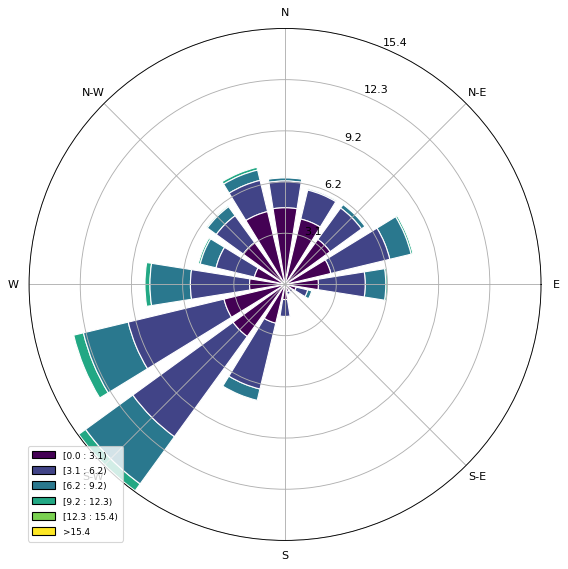

In [148]:
# Create an html map with Geoportail background and a windrose of the specific period
flux_data_snow_day = flux_NDVI[(flux_NDVI['phase_label'] == 'Snow') & (flux_NDVI['Night'] == False)]
map_footprint_snow_day = FFP_analys.map_footprint(flux_data_snow_day, lat_tower, lon_tower, coord_snow_day)
map_footprint_snow_day

In [149]:
# Save the map (optionnal)
#map_footprint_snow_day.save('map_footprint_snow_day.html')

## 2) 2) Overlay DSM (Digital Surface Model), IGN and footprint climatology

## Import MNT/DSM

In [150]:
# Open the elevation data
mnt_path = '/mnt/data-summer-shared/ICOS_Data_AliseROBERT/MNS2m_jardin.tif'

with rasterio.open(mnt_path) as src:
    mnt = src.read(1)
    mnt_extent = src.bounds
    mnt_crs = src.crs

## Convert station coordinates into the CRS of the raster

In [151]:
# Transformation of the coordinates
x0_mnt, y0_mnt = FFP_analys.transform_coordinates(lon_tower, lat_tower, crs_in="EPSG:4326", crs_out=mnt_crs)

## Crop the MNT to the domain size

In [152]:
# Define the limits to crop the MNT
domain_size = 400
bounds = (x0_mnt-domain_size, y0_mnt-domain_size, x0_mnt+domain_size, y0_mnt+domain_size)

In [153]:
# Crop the MNT with this limits
with rasterio.open(mnt_path) as src :
    window = from_bounds(*bounds, transform=src.transform)
    mnt_cropped = src.read(1, window=window)
    cropped_transform = src.window_transform(window)

## Calculate the relative altitudes to the tower (0 m at tower location)

In [154]:
# Calculate the tower altitude
row_cropped, col_cropped = rowcol(cropped_transform, x0_mnt, y0_mnt)
z0_cropped = mnt_cropped[row_cropped, col_cropped]

# Substract it to every value of the MNT
mnt_cropped_relative = mnt_cropped - z0_cropped

## Plot the 8 cases with MNT, roads and hydrography

In [155]:
# Set the titles for each case
titles = [
    'Snow - Night', 'Snow - Day',
    'Growth - Night', 'Growth - Day',
    'Stagnation - Night', 'Stagnation - Day',
    'Decline - Night', 'Decline - Day'
]

In [156]:
# Convert every contours into GeoDataFrame with the same CRS as the MNT
coord_all = []

for data in FFP_climato_all.values() :
    contours_coord = FFP_analys.contour_coord_extract(data,lon_tower, lat_tower)
    contours_gdf = FFP_analys.contours_to_gdf(contours_coord).to_crs(mnt_crs)
    coord_all.append(contours_gdf)

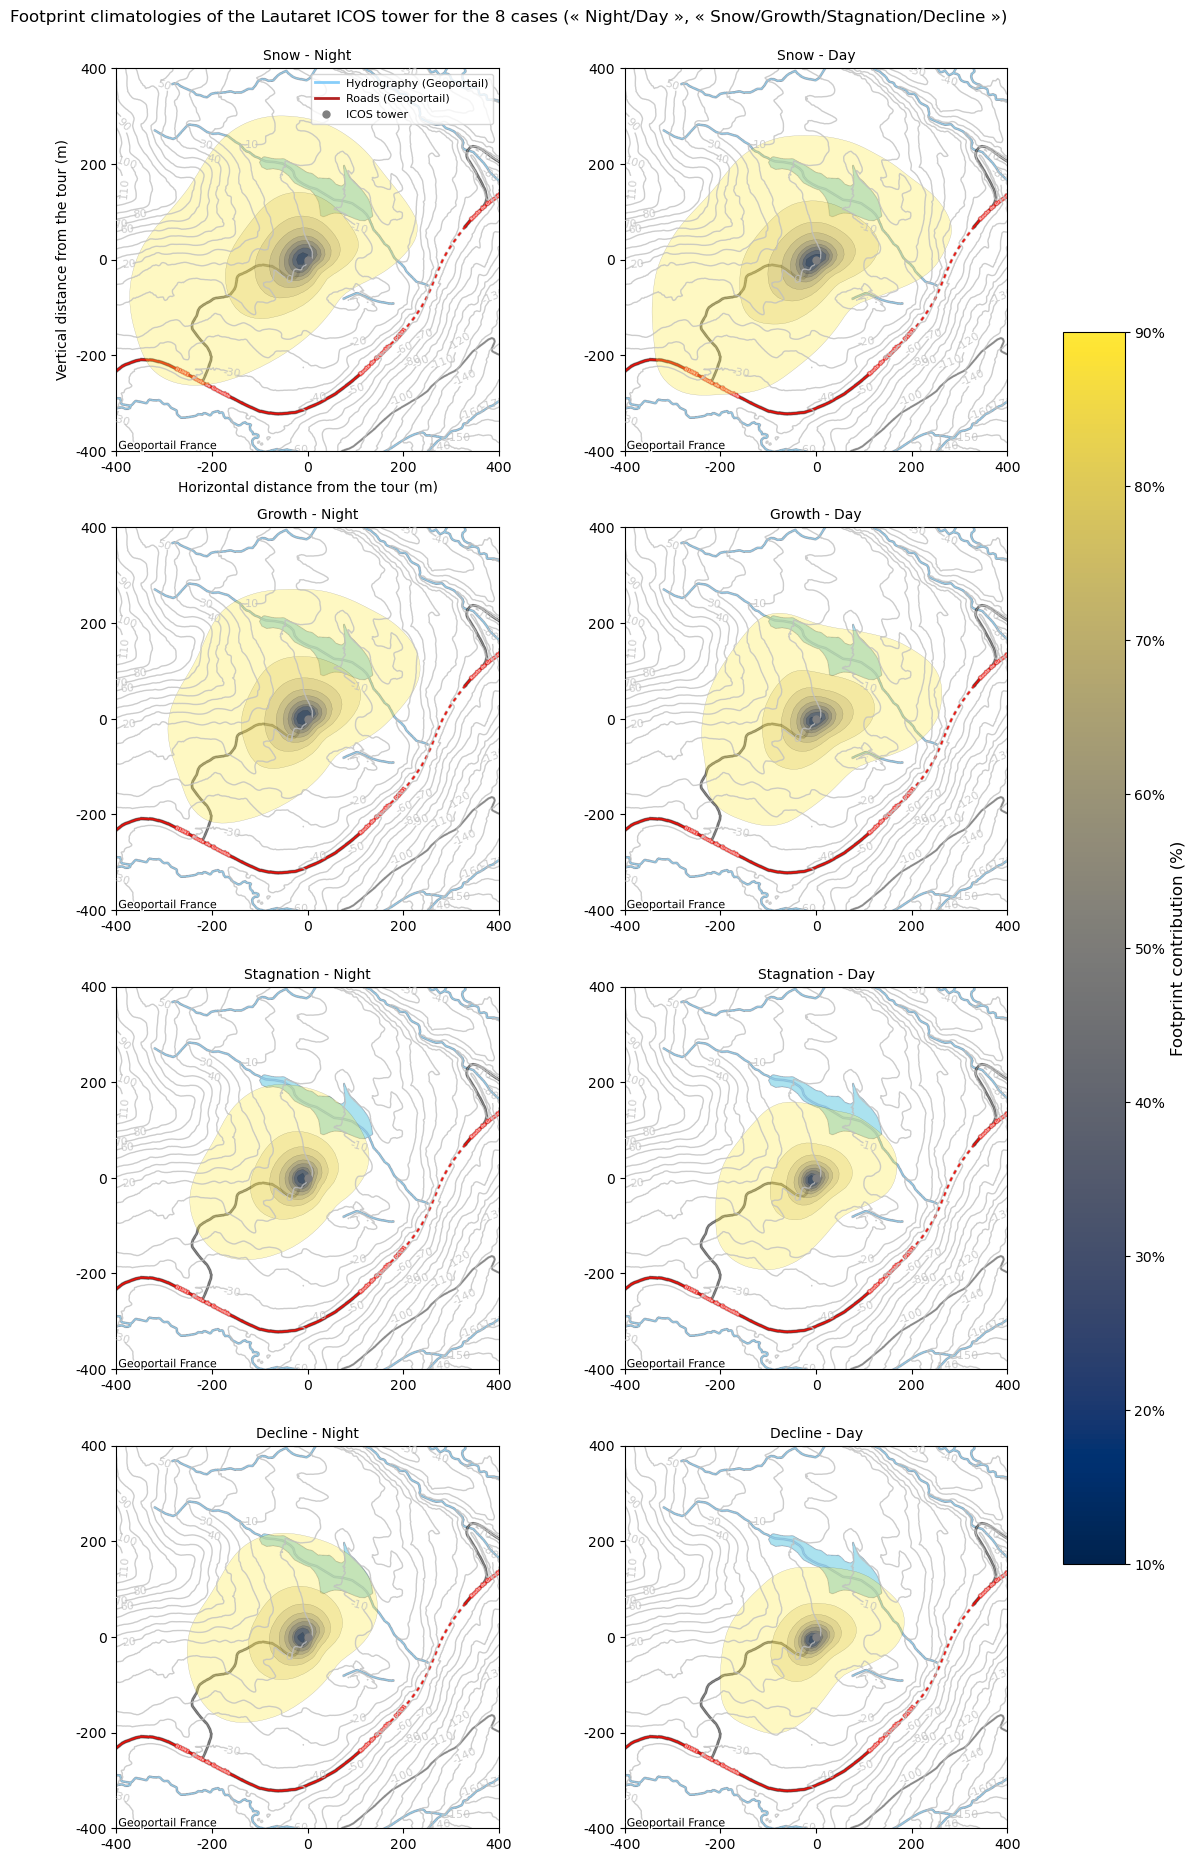

In [157]:
# Plot the 8 climatologies with additionnal info (hydrography, roads, elevation)
fig, axes = plt.subplots(4, 2, figsize=(20, 20))
axes = axes.flatten() 

fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=-0.5)

# Loop for each case
for i, (contours_gdf, ax) in enumerate(zip(coord_all, axes)):
    # Set y and x extent
    x_extent = np.array([x0_mnt - domain_size, x0_mnt + domain_size])
    y_extent = np.array([y0_mnt - domain_size, y0_mnt + domain_size])
    ax.set_xlim(x_extent)
    ax.set_ylim(y_extent)

    # Draw contour lines
    rows, cols = mnt_cropped_relative.shape
    x = np.linspace(x_extent[0], x_extent[1], cols)
    y = np.linspace(y_extent[1], y_extent[0], rows)
    X, Y = np.meshgrid(x, y)

    contour_lines = ax.contour(X, Y, mnt_cropped_relative, levels=30, colors="silver", linewidths=1, linestyles='solid', alpha=0.8)
    ax.clabel(contour_lines, inline=True, fontsize=8, fmt="%.0f") # Add the elevation value on the contour line

    # Add the footprint's contours
    contours_sorted = contours_gdf.sort_values(by="label", ascending=False)
    norm_fp = mcolors.Normalize(vmin=contours_gdf["label"].min(), vmax=contours_gdf["label"].max())

    contours_sorted.plot(
        column="label",
        cmap='cividis',
        norm=norm_fp,
        ax=ax,
        edgecolor="black",
        linewidth=0.2,
        alpha=0.3,
    )

    # Add a dot for the ICOS tower
    ax.plot(x0_mnt, y0_mnt, marker="o", color="grey", markersize=5, label='ICOS tower')

    # Add Geoportail background for roads and hydrographic network
    cx.add_basemap(ax, crs=mnt_crs, source=cx.providers.GeoportailFrance.Hydrography_Hydrography, alpha=1)
    cx.add_basemap(ax, crs=mnt_crs, source=cx.providers.GeoportailFrance.Transportnetworks_Roads, alpha=1)

    ax.set_xticks(np.linspace(x_extent[0], x_extent[1], 5))
    ax.set_yticks(np.linspace(y_extent[0], y_extent[1], 5))
    ax.set_xticklabels([int(x - x0_mnt) for x in np.linspace(x_extent[0], x_extent[1], 5)])
    ax.set_yticklabels([int(y - y0_mnt) for y in np.linspace(y_extent[0], y_extent[1], 5)])

    ax.set_title(titles[i], fontsize=10)

    if i == 0 :
        ax.set_xlabel("Horizontal distance from the tour (m)")
        ax.set_ylabel("Vertical distance from the tour (m)")

        # Legend for Geoportail background
        legend_elements = [
            Line2D([0], [0], color='lightskyblue', lw=2, label='Hydrography (Geoportail)'),
            Line2D([0], [0], color='firebrick', lw=2, label='Roads (Geoportail)'),
            Line2D([0], [0], marker='o', color='grey', lw=0, label='ICOS tower', markersize=5)
        ]
        ax.legend(handles=legend_elements, loc='upper right', fontsize=8)

# Add a colorbar with the percentage of footprint contribution
sm = ScalarMappable(cmap='cividis', norm=norm_fp)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', shrink=0.7, pad=0.03)
cbar.set_label("Footprint contribution (%)", fontsize=12)
cbar.formatter = mticker.FuncFormatter(lambda x, pos: f"{x*100:.0f}%")
cbar.update_ticks()

plt.title("Footprint climatologies of the Lautaret ICOS tower for the 8 cases (« Night/Day », « Snow/Growth/Stagnation/Decline »)", loc= 'right',y=4.7)

plt.savefig('all_footprints.png')
plt.show()

The footprint climatologies are represented by colored areas for each value of the contribution to the footprint (from 10 to 90%). The relief is illustrated by contour lines showing the relative altitude to the tower (m), located at the grey point in the middle of the map. In the background, the hydrological elements are shown in blue and the main road axis in red. **This plot shows that for all cases, the wetland is contained in whole or in part in the flux footprint. It contributes more to the measured flux during the "snow" and "vegetation growth" phases. The extent and shape of the footprint climatology is also variable between day and night, for a given period. Throughout the year, the beginning of the ridges in the Northwest is also captured by the tower. This more pronounced relief, as well as the main road for "Snow" conditions, can influence the emission and transport of CO2 in the atmosphere.**

# 3) Save in daily netCDF files for further work

**Warning : the following cell is particularly time-consuming, only run it if necessary**

In [72]:
# Calculate every single footprint climatology and save it in a netCDF file
#FFP_analys.data_to_daily_nc(flux_NDVI, '/home/jovyan/private-storage/data-runs-daily2/')

In [73]:
# Example for output netCDF file
xr_test = xr.open_dataset('/mnt/data-summer-shared/ICOS_Data_AliseROBERT/footprint_2019-06-01.nc')
xr_test

<xarray.Dataset> Size: 111MB
Dimensions:    (timestamp: 44, x: 561, y: 561)
Coordinates:
  * x          (x) float64 4kB -700.0 -697.5 -695.0 -692.5 ... 695.0 697.5 700.0
  * y          (y) float64 4kB -700.0 -697.5 -695.0 -692.5 ... 695.0 697.5 700.0
  * timestamp  (timestamp) datetime64[ns] 352B 2019-06-01 ... 2019-06-01T23:3...
Data variables:
    footprint  (timestamp, x, y) float64 111MB ...
    night      (timestamp) <U5 880B ...
    phase      (timestamp) <U6 1kB ...
Attributes: (12/15)
    Title:                        Single flux footprints ICOS Lautaret (2019-...
    Summary:                      Flux footprints integrated over 30 min from...
    Subjects:                     Flux footprint, grassland CO2 flux, ICOS
    Creation_Date:                2025-06-24
    Conventions:                  CF-1.8
    Model_Used:                   FFP, Kljun et al. (2015), doi:10.5194/gmd‐8...
    ...                           ...
    Aknowledgement:               This work is the result of a M2 internship ...
    Variables:                    X, Y, Timestamp, Night, Phase Label, Footpr...
    Coordinate_Reference_System:  
    Tower_Location_Latitude:      45.041375
    Tower_Location_Longitude:     6.410519
    Tower_Location_CRS:           WGS 84

## Select only interesting footprints (netCDF files) and aggregate

From these saved netCDF files, containing the footprint values for each timestamp, it is possible to select only certain periods under specific conditions. The footprint values are then aggregated (averaged and smoothed) with the Kljun method. Here is an example :

In [74]:
# Aggregate the footprint values for Stagnation/Night
clim_test = FFP_analys.aggregate_nc_footprints(folder_path = '/home/jovyan/private-storage/data-runs-daily2/', dx = 2.5, dy = 2.5, rs = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90], Phase="Stagnation", Night="True")

Processing netCDF files: 100%|██████████| 1771/1771 [09:55<00:00,  2.97it/s]


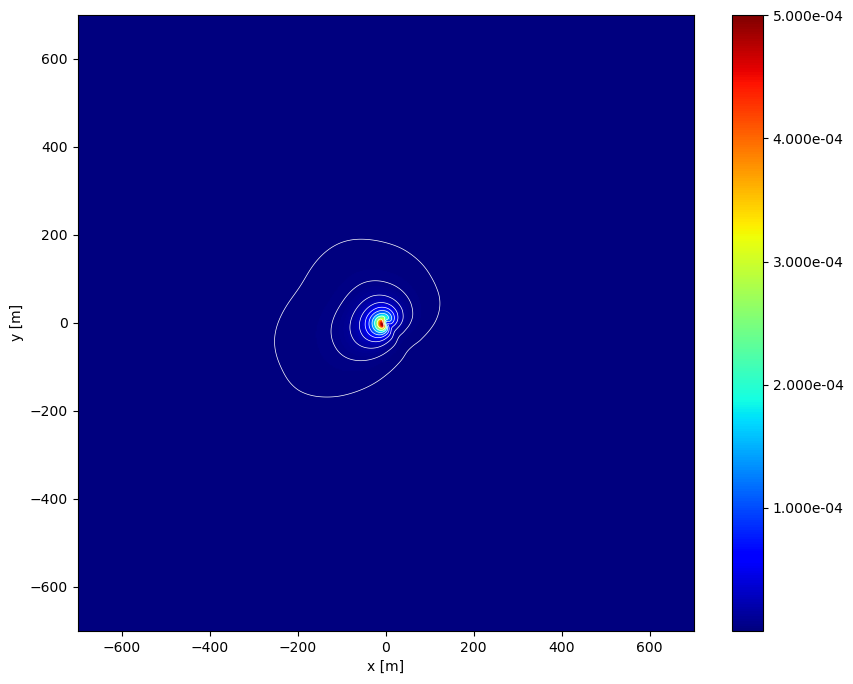

(<Figure size 1000x800 with 2 Axes>, <Axes: xlabel='x [m]', ylabel='y [m]'>)

In [75]:
# Check the result : plot the obtain aggregation
myfootprint_climato.plot_footprint(x_2d=clim_test['x_2d'], y_2d=clim_test['y_2d'], fs=clim_test['fclim_2d'],clevs=clim_test['fr'])

The resulting figure for Stagnation/Night is the same as the footprint climatology in section 2)2). This function "aggregate_nc_footprints" is useful for plotting footprints for specific periods from daily netCDF files.

# 4) Limits : invalid timestamps for FFP calculation

## General observation

In [76]:
# Get all nc files from the folder (change the path if necessary)
folder_path = '/home/jovyan/private-storage/data-runs-daily2/'
nc_files = glob.glob(os.path.join(folder_path, '*.nc'))

In [78]:
# Collect all the valid timestamps, existing in the netCDF files
timestamp_valid = []

for file in tqdm(nc_files, desc = 'Processing netCDF files') :
    try:
        with xr.open_dataset(file) as dataset:
            timestamps = dataset['timestamp'].values
            timestamp_valid.append(timestamps)

    except Exception as e:
        print(f'Error with file {file} : {e}')

Processing netCDF files: 100%|██████████| 1771/1771 [07:20<00:00,  4.02it/s]


In [158]:
# Put them in one dataframe
all_valid_timestamps = np.concatenate(timestamp_valid)
all_valid_timestamps = np.sort(all_valid_timestamps)

In [166]:
all_valid_timestamps

array(['2019-06-01T00:00:00.000000000', '2019-06-01T01:30:00.000000000',
       '2019-06-01T02:00:00.000000000', ...,
       '2024-12-12T08:00:00.000000000', '2024-12-12T08:30:00.000000000',
       '2024-12-12T09:30:00.000000000'],
      shape=(73959,), dtype='datetime64[ns]')

In [159]:
# Create a regular index (one timestamp every 30 min) : theoric total timestamps from 2019 to 2024
full_index = pd.date_range(start='2020-01-01 00:00:00', end='2024-12-12 23:30:00', freq='30min')

In [160]:
# Create a flag : if the timestamp is in the netCDF files, it is equal to 1 (valid for FFP calculation), otherwise 0
valid = full_index.isin(all_valid_timestamps).astype(int)

In [161]:
# Count the invalid and valid timestamps
np.unique(valid, return_counts=True)

(array([0, 1]), array([16616, 70168]))

In the original dataset, 19% of the total timestamps are not valid for FFP calculation from 2020 to 2024.

In [170]:
# Cumulative sum and percentage of valid data
n = len(full_index)
valid_cumsum = np.cumsum(valid)
valid_ffp = valid_cumsum / n

In [171]:
# Cumulative percentage for an ideal case with all valid timestamps
ideal_cumsum = np.arange(1, n+1)
ideal_valid = ideal_cumsum / n

<function matplotlib.pyplot.show(close=None, block=None)>

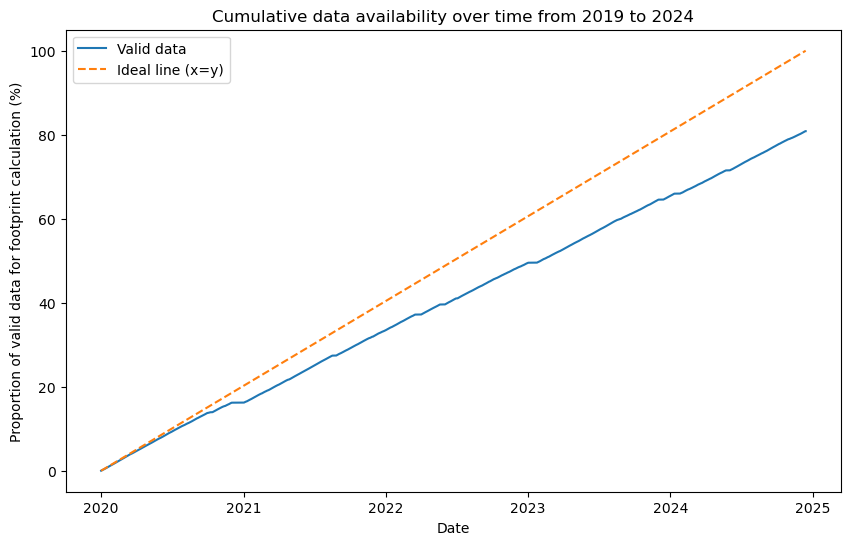

In [172]:
# Plot the cumulative percentage of valid data : ideal VS real dataset
df_valid = pd.DataFrame({"timestamp": full_index, "valid_count" : valid, "valid_ffp": valid_ffp, "ideal_valid": ideal_valid})

fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(df_valid['timestamp'],df_valid['valid_ffp']*100, label='Valid data')

ax.plot(df_valid['timestamp'], df_valid['ideal_valid']*100, linestyle = 'dashed', label = 'Ideal line (x=y)')
ax.set_xlabel('Date')
ax.set_ylabel('Proportion of valid data for footprint calculation (%)')
ax.legend()
ax.set_title('Cumulative data availability over time from 2019 to 2024')

plt.savefig('data_valid_ffp.png')
plt.show

This graph shows that the proportion of valid data does not reach 100% and the cumulative availability gradually decreases from 2021 to 2024. **It is now necessary to determine whether certain specific periods are particularly affected by this lack of data, and therefore under-represented in the climatologies plotted by the FFP model.**

## Detailed missing/wrong periods

In [173]:
# Count invalid dates by month
invalid_dates = df_valid.loc[df_valid['valid_count'] == 0, 'timestamp']
invalid_dates_month = invalid_dates.dt.month.value_counts().sort_index()

In [174]:
# Calculate the percentage of invalid data per month
df_valid['ideal_count'] = 1
invalid_dates_month / df_valid['ideal_count'].groupby(df_valid['timestamp'].dt.month).sum()

timestamp
1     0.322312
2     0.112676
3     0.218683
4     0.102778
5     0.232796
6     0.091806
7     0.104032
8     0.194086
9     0.134028
10    0.186290
11    0.182361
12    0.430147
dtype: float64

In [175]:
# Count invalid dates by hour
invalid_dates_hour = invalid_dates.dt.hour.value_counts().sort_index()

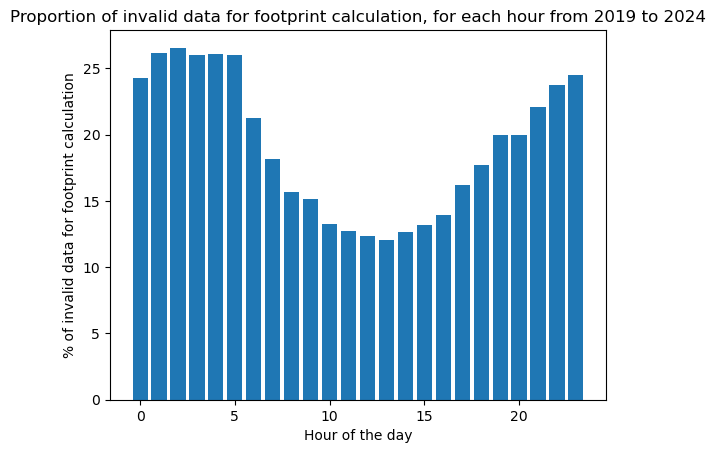

In [176]:
# Create a bar plot to show the percentage of invalid data for each hour
plt.bar(invalid_dates_hour.index, invalid_dates_hour / df_valid['ideal_count'].groupby(df_valid['timestamp'].dt.hour).sum()*100)
plt.xlabel('Hour of the day')
plt.ylabel("% of invalid data for footprint calculation")
plt.title('Proportion of invalid data for footprint calculation, for each hour from 2019 to 2024')
plt.savefig('unvalid_ffp_hour.png')

There are more invalid data during night (up to 25%) and winter (43% and 32% for December and January). **It would be necessary to further investigate the causes of this phenomenon (atmospheric stability, missing input parameters...) in order to determine the impact on the modeling and interpretation of the flux footprint.**

# Conclusion

Accurate knowledge of the position and size of surface source areas and their contribution to the measured CO<sub>2</sub> flux is of crucial importance to interpret flux tower measurements. In this work, the footprint extent and its evolution over the seasons can be determined using the FFP model of Kljun et al. (2015). Cross-referenced with field information, this is of great interest for more specific future questions: What is the contribution of the wetland to the measured flux? Do CO<sub>2</sub> exchanges differ depending on wind orientation and source areas ? The output data from this notebook (netCDF files containing footprint values) will be used for model comparison.